In [1]:

# module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv("C:/Users/charl/Downloads/heart+disease_1/reprocessed.hungarian.data", header=None)
data = data[0].str.split(expand=True)

In [3]:
data.head

<bound method NDFrame.head of      0  1  2    3    4  5  6    7   8    9   10  11  12 13
0    40  1  2  140  289  0  0  172   0    0  -9  -9  -9  0
1    49  0  3  160  180  0  0  156   0    1   2  -9  -9  1
2    37  1  2  130  283  0  1   98   0    0  -9  -9  -9  0
3    48  0  4  138  214  0  0  108   1  1.5   2  -9  -9  3
4    54  1  3  150   -9  0  0  122   0    0  -9  -9  -9  0
..   .. .. ..  ...  ... .. ..  ...  ..  ...  ..  ..  .. ..
289  48  0  2   -9  308  0  1   -9  -9    2   1  -9  -9  0
290  36  1  2  120  166  0  0  180   0    0  -9  -9  -9  0
291  48  1  3  110  211  0  0  138   0    0  -9  -9   6  0
292  47  0  2  140  257  0  0  135   0    1   1  -9  -9  0
293  53  1  4  130  182  0  0  148   0    0  -9  -9  -9  0

[294 rows x 14 columns]>

In [4]:
new_column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]
data.columns = new_column_names
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,40,1,2,140,289,0,0,172,0,0,-9,-9,-9,0
1,49,0,3,160,180,0,0,156,0,1,2,-9,-9,1
2,37,1,2,130,283,0,1,98,0,0,-9,-9,-9,0
3,48,0,4,138,214,0,0,108,1,1.5,2,-9,-9,3
4,54,1,3,150,-9,0,0,122,0,0,-9,-9,-9,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       294 non-null    object
 1   sex       294 non-null    object
 2   cp        294 non-null    object
 3   trestbps  294 non-null    object
 4   chol      294 non-null    object
 5   fbs       294 non-null    object
 6   restecg   294 non-null    object
 7   thalach   294 non-null    object
 8   exang     294 non-null    object
 9   oldpeak   294 non-null    object
 10  slope     294 non-null    object
 11  ca        294 non-null    object
 12  thal      294 non-null    object
 13  target    294 non-null    object
dtypes: object(14)
memory usage: 32.3+ KB


In [74]:
# oldpeak 열을 제외한 모든 열을 'int64'로 변환
data.loc[:, data.columns != 'oldpeak'] = data.loc[:, data.columns != 'oldpeak'].astype('int64')

# oldpeak 열을 'float64'로 유지
data['oldpeak'] = data['oldpeak'].astype('float64')

# 데이터 유형 출력
print(data.dtypes)


age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


In [75]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [76]:

!pip install sweetviz
import sweetviz

                                             |          | [  0%]   00:00 -> (? left)


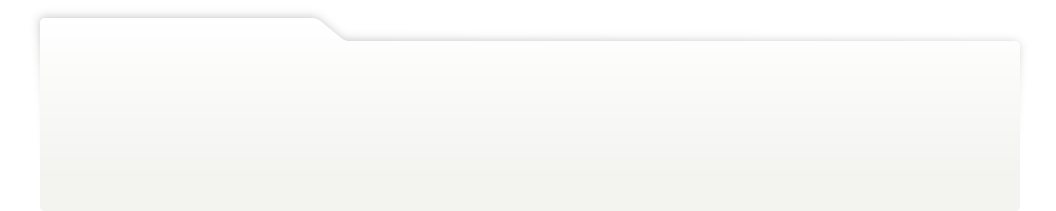
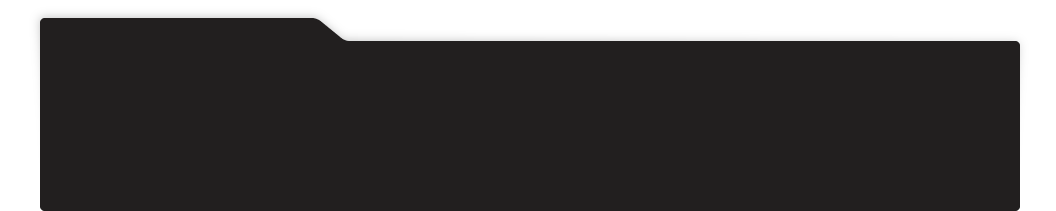
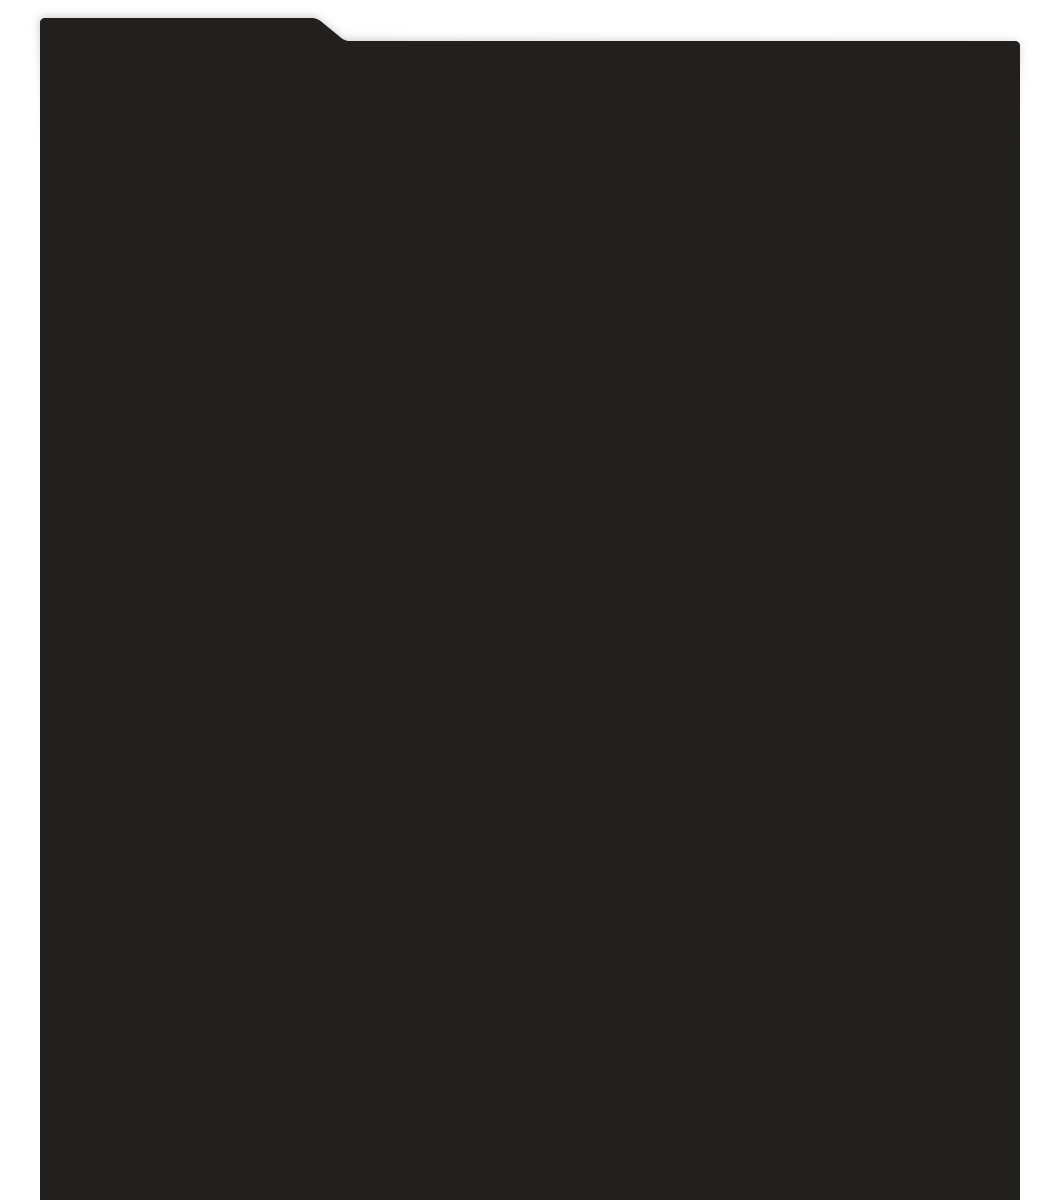
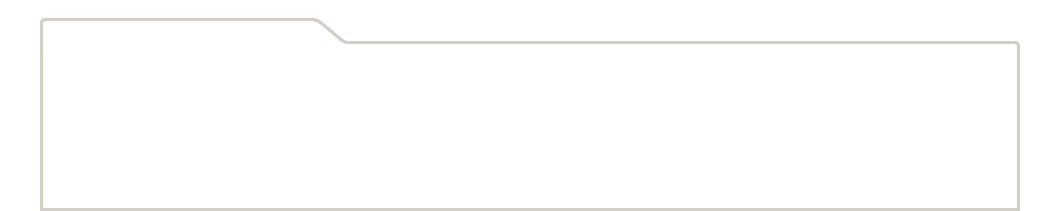
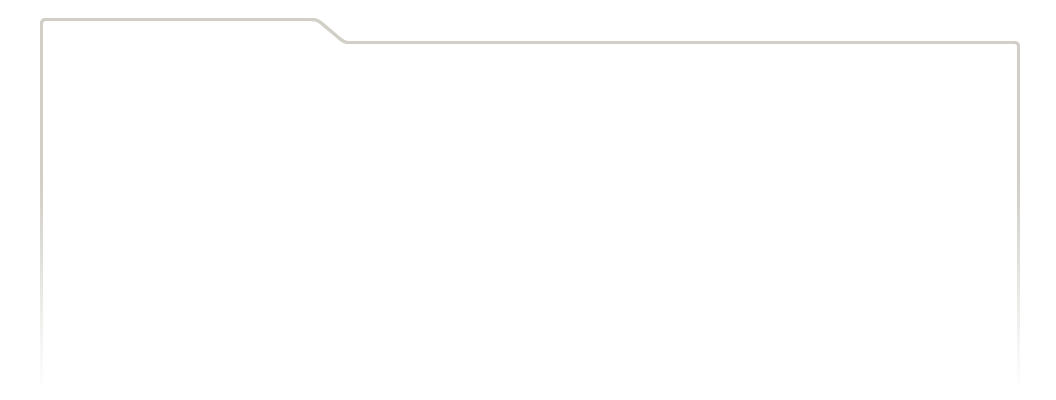
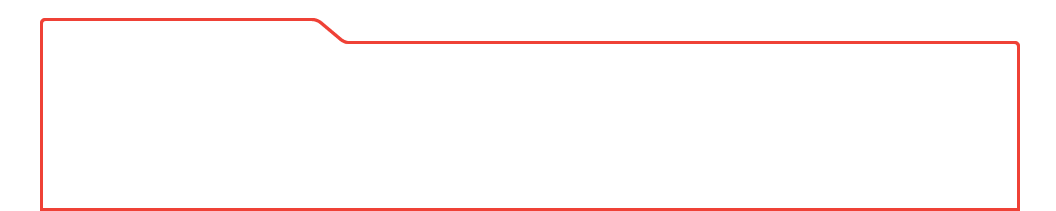
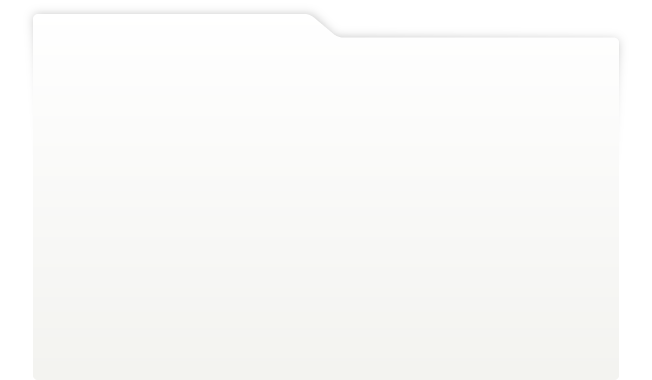
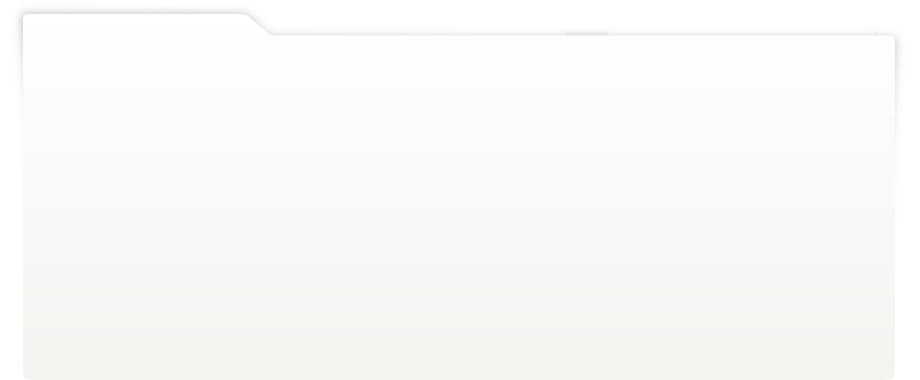
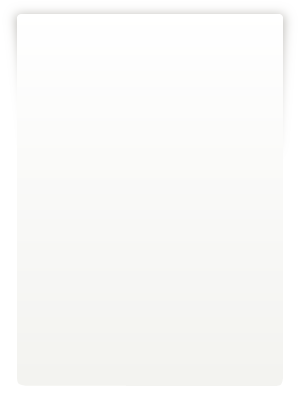
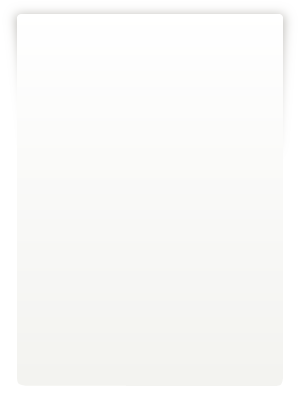
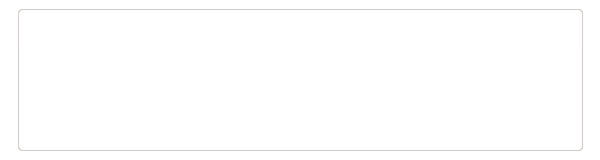
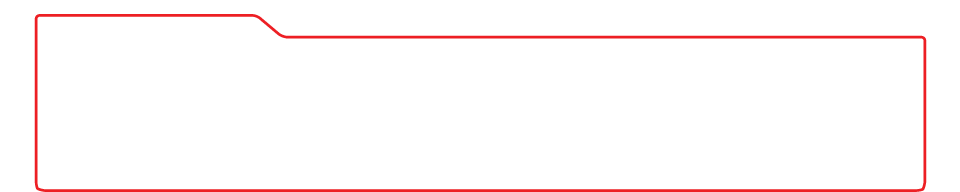
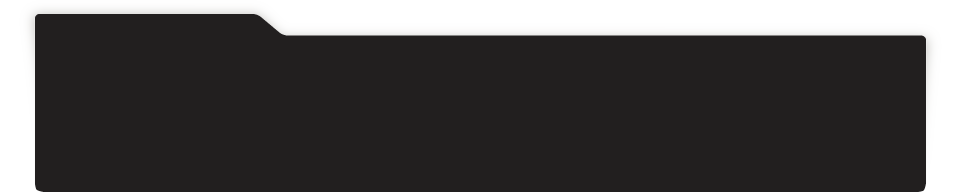
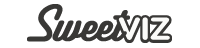
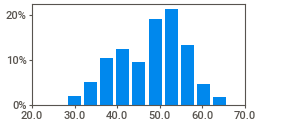
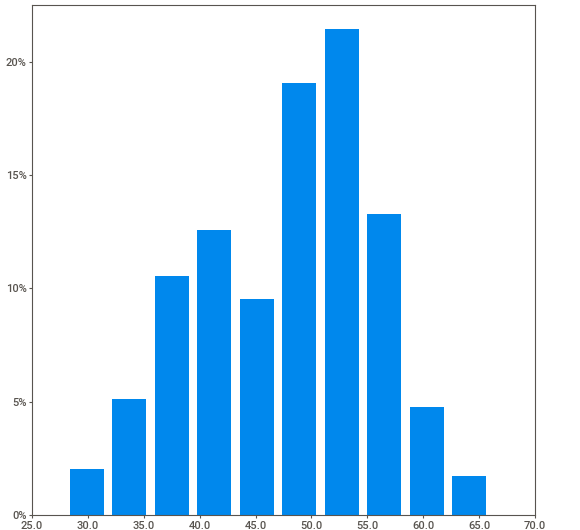
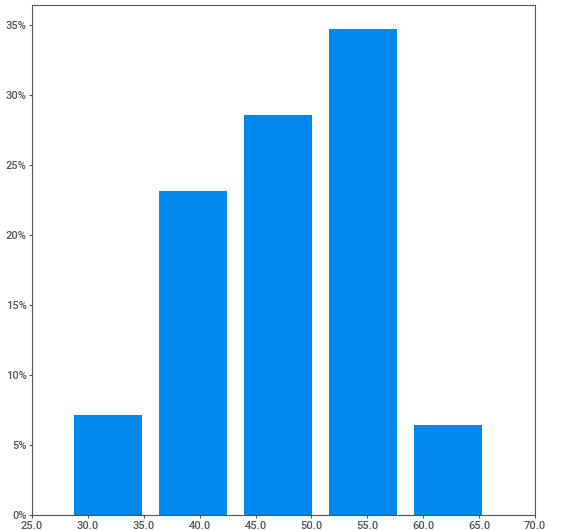
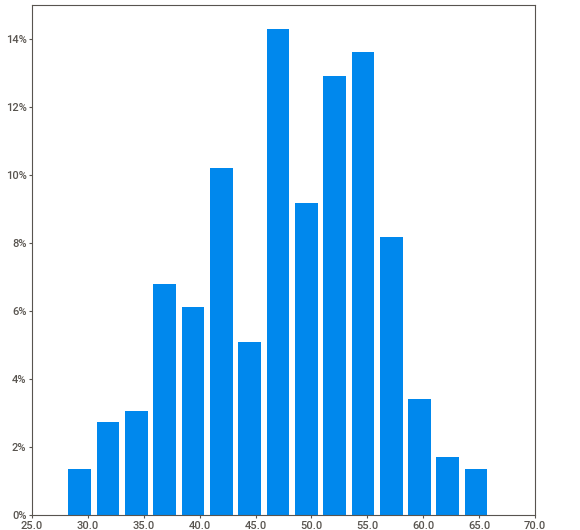
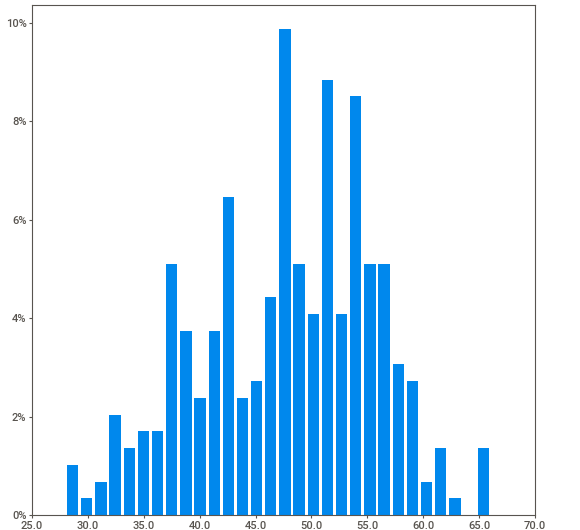
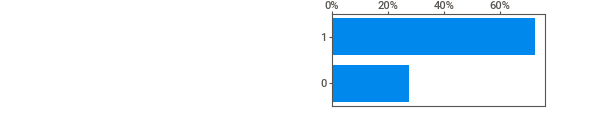
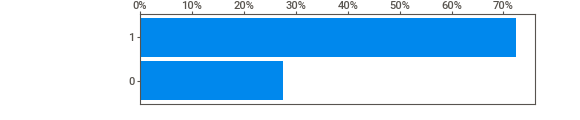
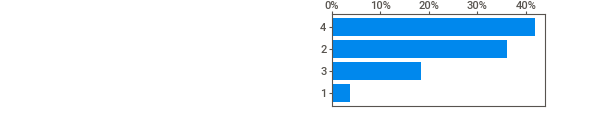
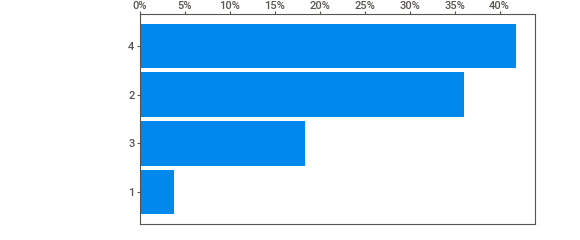
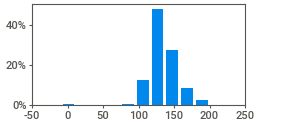
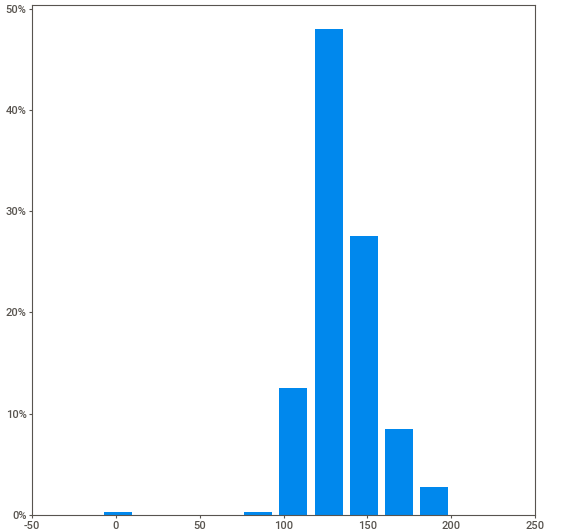
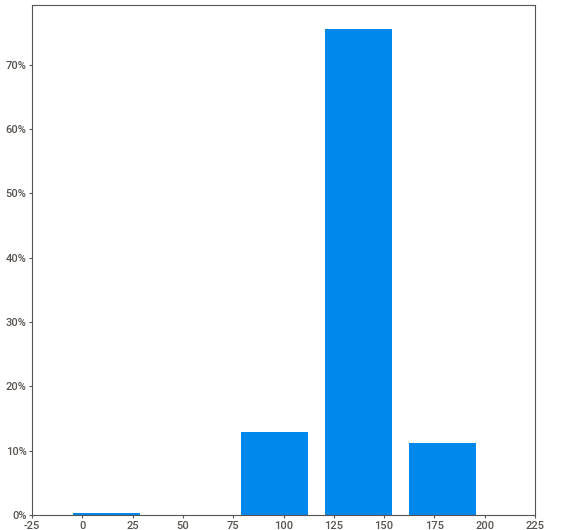
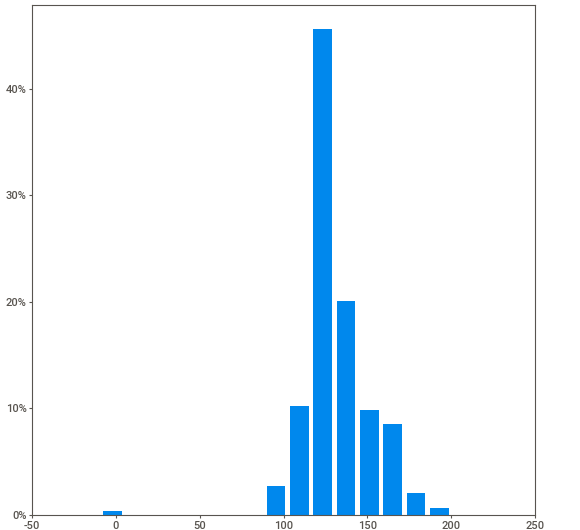
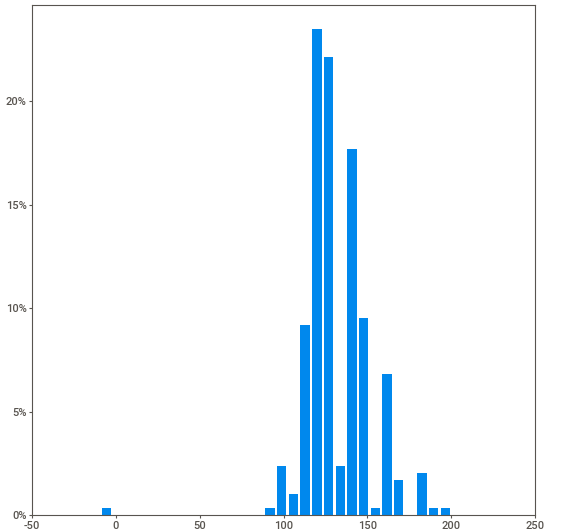
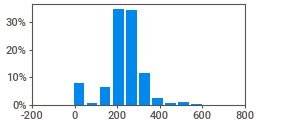
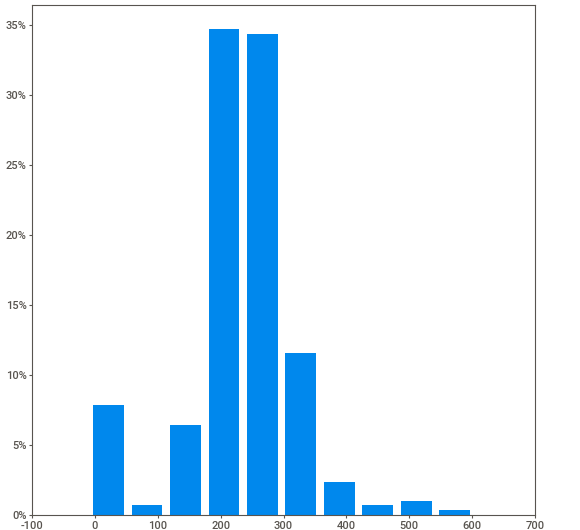
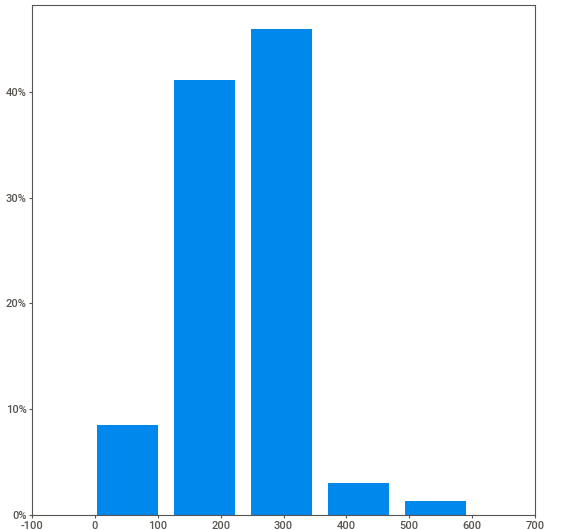
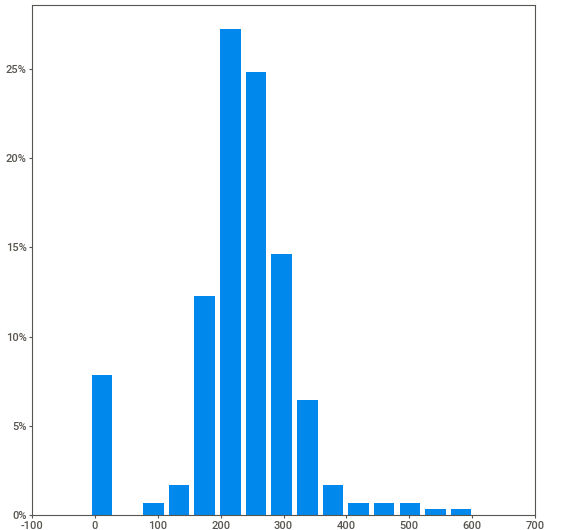
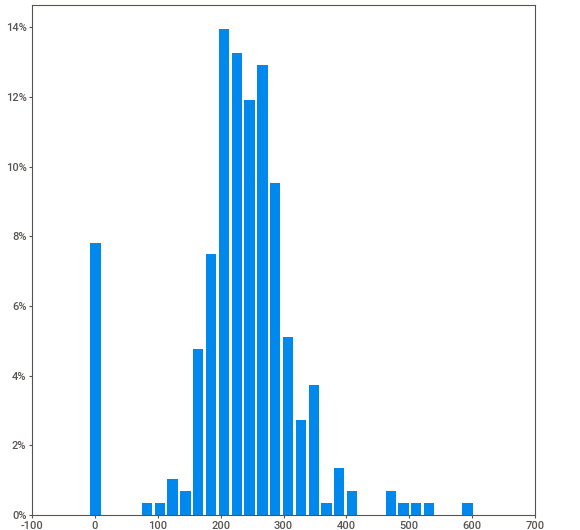
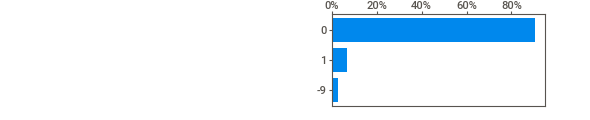
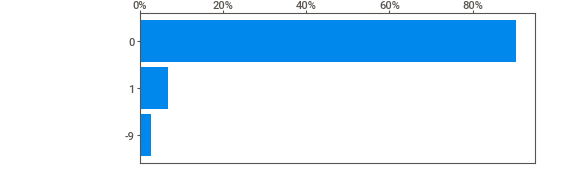
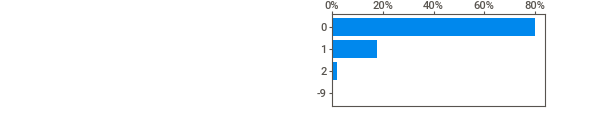
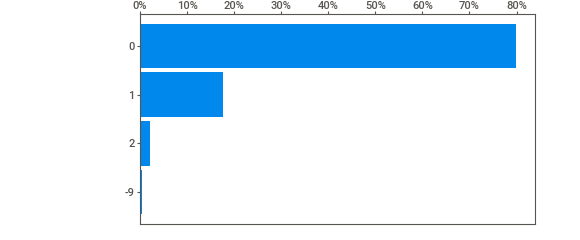
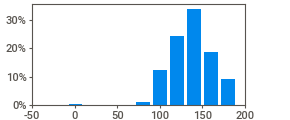
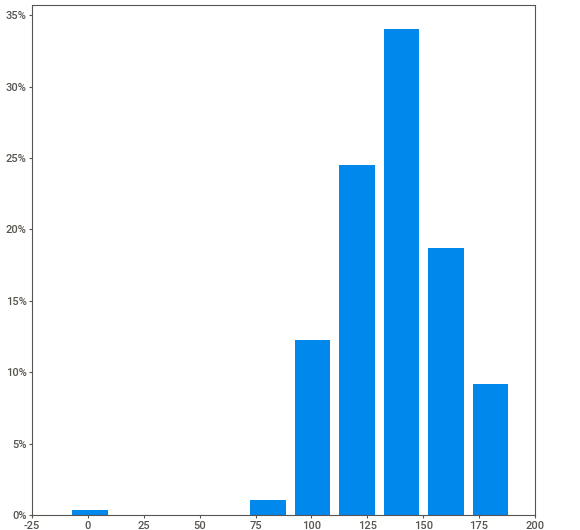
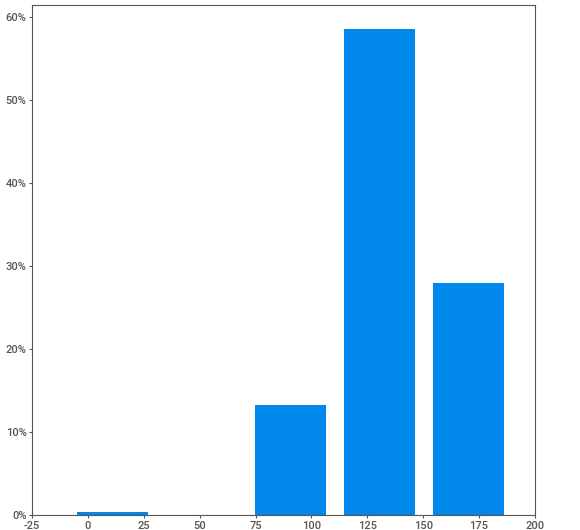
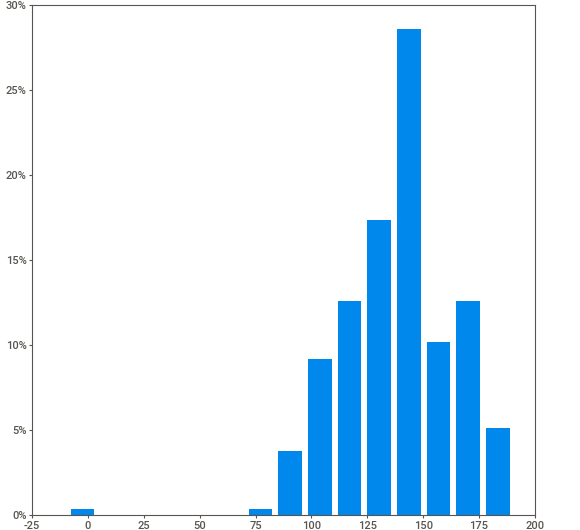
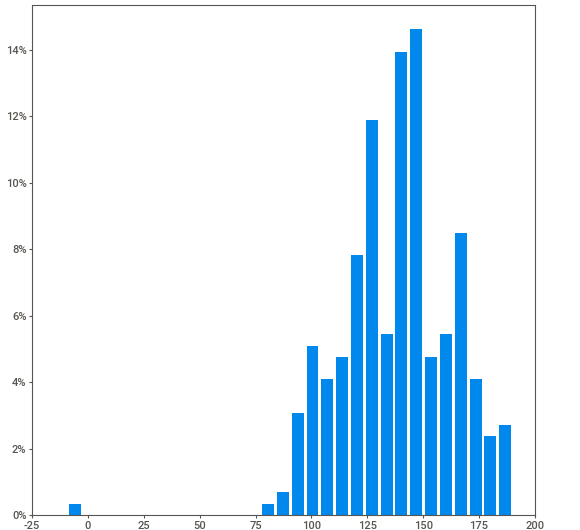
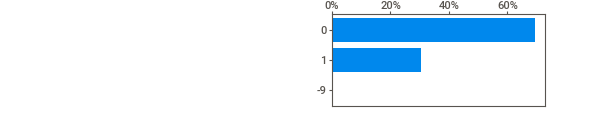
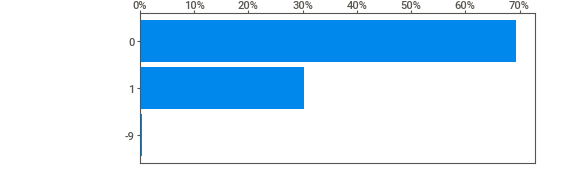
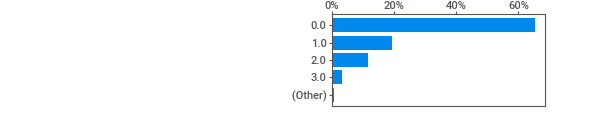
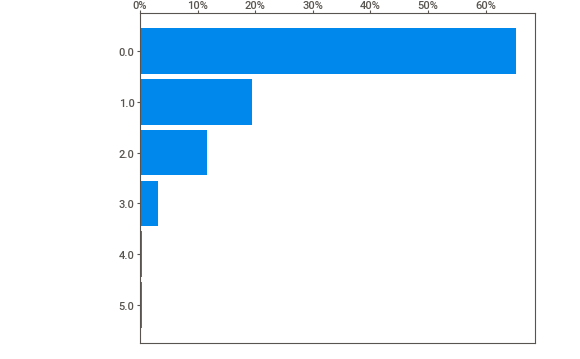
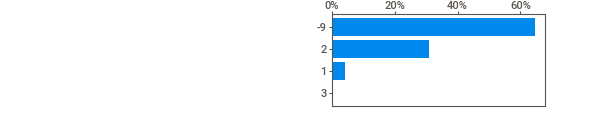
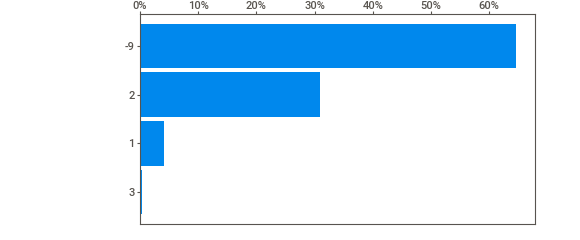
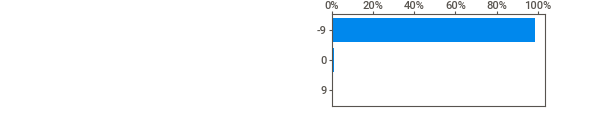
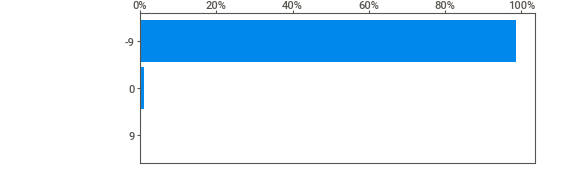
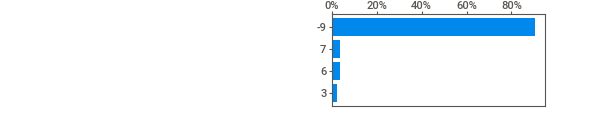
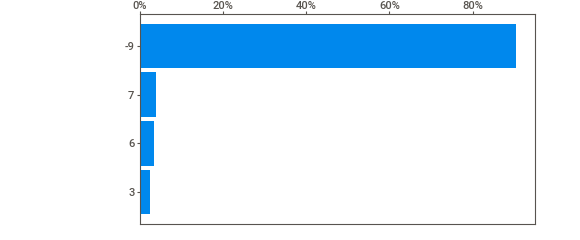
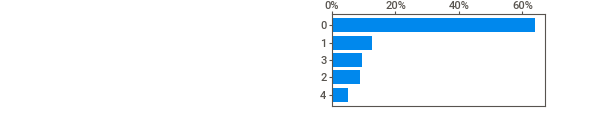
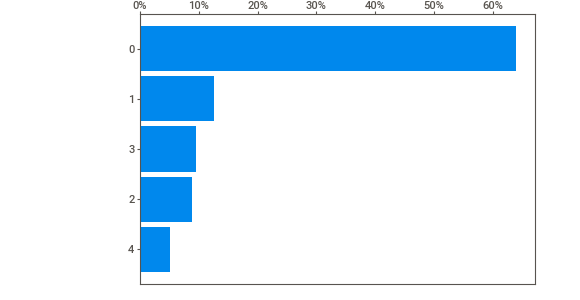
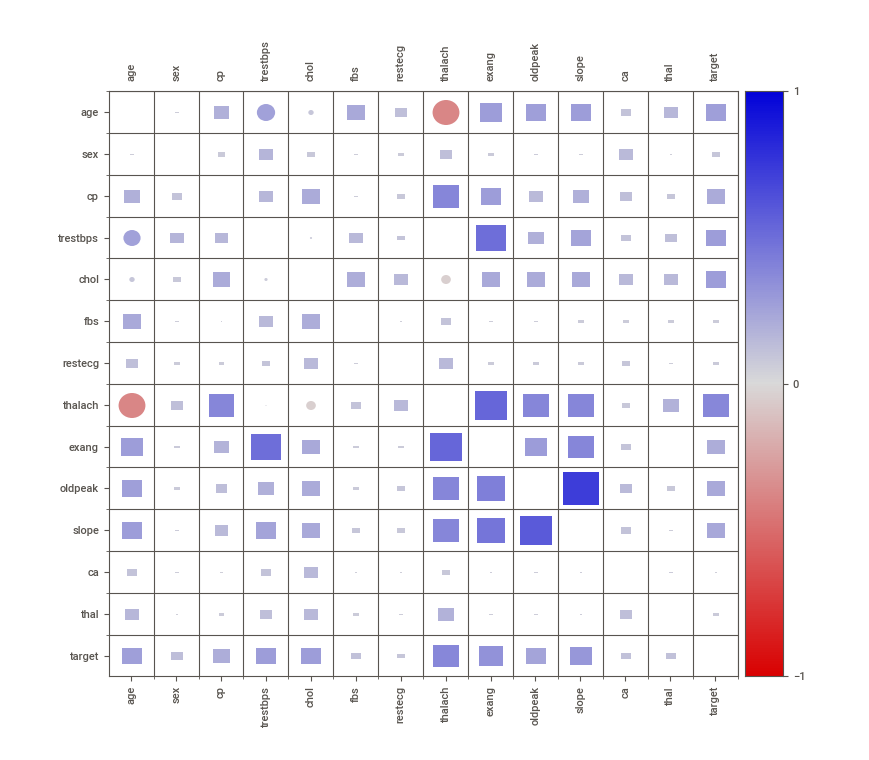
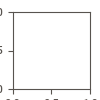

In [77]:
sweetviz.analyze(data).show_notebook()

In [78]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [79]:
y = data["target"]
X = data.drop('target',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [81]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((235, 13), (59, 13), (235,), (59,))

In [82]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [83]:

# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

# Apply sequence transformation using time step of 25 for both train and test data
# All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity.

X_train, y_train = split_sequences(train_set, 5)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 5)
print(X_test.shape, y_test.shape)

(231, 5, 13) (231,)
(55, 5, 13) (55,)


In [84]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((231, 5, 13), (55, 5, 13), (231,), (55,))

In [85]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Input
from keras.layers import Dense, Flatten, Dropout
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [86]:

y_train_onehot = pd.get_dummies(y_train).values
y_test_onehot = pd.get_dummies(y_test).values

In [87]:

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_onehot.shape[1]
print(n_timesteps, n_features, n_outputs)

5 13 5


In [112]:
model = Sequential()

# Convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Conv1D(filters=80, kernel_size=3, activation='relu'))

# Dropout and MaxPooling
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=1))

# LSTM layer
model.add(LSTM(100))

# Dropout and Dense layers
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 3, 64)             2560      
                                                                 
 dropout_39 (Dropout)        (None, 3, 64)             0         
                                                                 
 conv1d_36 (Conv1D)          (None, 1, 80)             15440     
                                                                 
 dropout_40 (Dropout)        (None, 1, 80)             0         
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 1, 80)            0         
 g1D)                                                            
                                                                 
 lstm_29 (LSTM)              (None, 100)               72400     
                                                     

In [113]:
train_epochs = 30
history = model.fit(X_train, y_train_onehot, epochs=train_epochs, verbose=True,  validation_split = 0.1)

Epoch 1/30
7/7 [==============================] - 2s 87ms/step - loss: 1.5892 - accuracy: 0.3043 - val_loss: 1.5214 - val_accuracy: 0.5417
Epoch 2/30
7/7 [==============================] - 0s 11ms/step - loss: 1.4221 - accuracy: 0.6618 - val_loss: 1.4219 - val_accuracy: 0.5417
Epoch 3/30
7/7 [==============================] - 0s 10ms/step - loss: 1.2600 - accuracy: 0.6570 - val_loss: 1.3756 - val_accuracy: 0.5417
Epoch 4/30
7/7 [==============================] - 0s 9ms/step - loss: 1.1483 - accuracy: 0.6570 - val_loss: 1.4405 - val_accuracy: 0.5417
Epoch 5/30
7/7 [==============================] - 0s 9ms/step - loss: 1.1356 - accuracy: 0.6570 - val_loss: 1.4148 - val_accuracy: 0.5417
Epoch 6/30
7/7 [==============================] - 0s 9ms/step - loss: 1.0775 - accuracy: 0.6570 - val_loss: 1.3559 - val_accuracy: 0.5417
Epoch 7/30
7/7 [==============================] - 0s 8ms/step - loss: 1.0923 - accuracy: 0.6570 - val_loss: 1.3297 - val_accuracy: 0.5417
Epoch 8/30
7/7 [===============

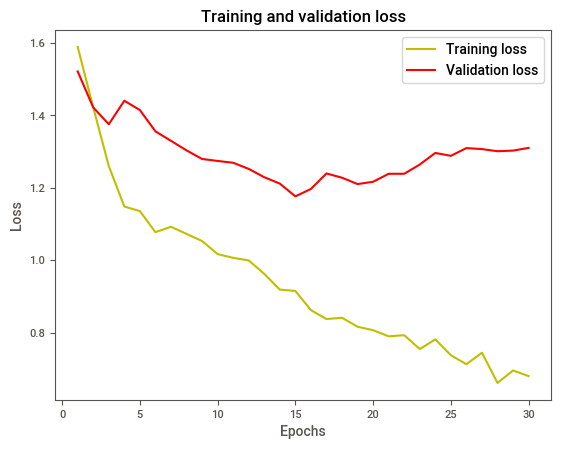

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

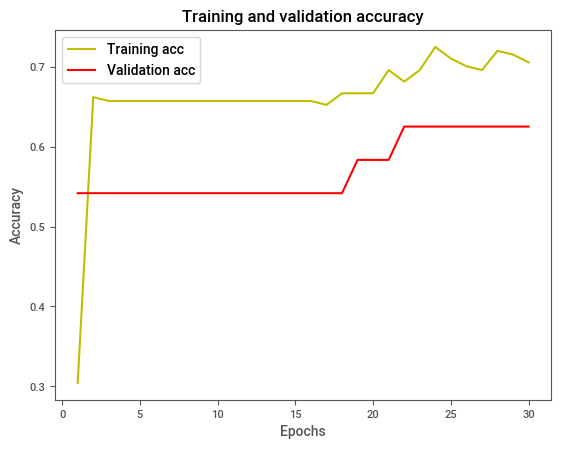

In [115]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [116]:

#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix


y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test_onehot,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

2/2 [==============================] - 1s 3ms/step


In [117]:
#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81        33
           1       0.00      0.00      0.00         9
           2       0.33      0.33      0.33         6
           3       0.15      0.40      0.22         5
           4       0.00      0.00      0.00         2

    accuracy                           0.58        55
   macro avg       0.25      0.32      0.27        55
weighted avg       0.52      0.58      0.54        55

[[28  0  0  5  0]
 [ 4  0  1  4  0]
 [ 2  0  2  2  0]
 [ 2  0  1  2  0]
 [ 0  0  2  0  0]]


C:\Users\charl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\charl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\charl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
